# ⚡ Notebook 1: Experimental Data Quality & Anomaly Detection

**Objective:** Assess data quality from an electrocatalyst screening campaign and identify experimental artifacts.

**Why this matters for materials discovery:**
In high-throughput screening, experimental artifacts can masquerade as real chemical effects. A data scientist must:
- Distinguish signal from noise
- Identify systematic errors (temperature drift, reference electrode instability, instrument failures)
- Provide actionable feedback to lab teams on data quality
- Ensure downstream ML models are trained on reliable measurements

**Author:** Alex Domingues Batista, PhD  
**Target Role:** Chemical Data Scientist

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 2. Load Dataset and Initial Inspection

We'll load Campaign 1 data from a high-throughput electrocatalyst screening run. This campaign tested ~100 Pt-Ru-Ir ternary catalyst compositions for oxygen evolution reaction (OER) activity.

In [2]:
# Load Campaign 1 data
df = pd.read_csv('data/campaign_1_results.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (120, 17)

Columns: ['sample_id', 'campaign', 'timestamp', 'Pt_percent', 'Ru_percent', 'Ir_percent', 'overpotential_V', 'tafel_slope_mV_dec', 'exchange_current_A_cm2', 'charge_transfer_resistance_Ohm_cm2', 'surface_area_m2_g', 'temperature_C', 'pH', 'replicate_std', 'measurement_quality', 'operator', 'instrument_id']

First few rows:


,sample_id,campaign,timestamp,Pt_percent,Ru_percent,Ir_percent,overpotential_V,tafel_slope_mV_dec,exchange_current_A_cm2,charge_transfer_resistance_Ohm_cm2,surface_area_m2_g,temperature_C,pH,replicate_std,measurement_quality,operator,instrument_id
0,CAT-01-001,1,2025-01-01 00:00:00,55.0,34.2,10.8,0.2698,30.0,0.000014,59.41,53.1,24.78,1.18,0.0180,1,Charlie,POTENTIOSTAT-01
1,CAT-01-002,1,2025-01-01 02:00:00,78.0,36.9,-14.9,0.2451,114.4,0.000007,130.13,71.3,25.73,0.89,0.0170,1,Charlie,POTENTIOSTAT-01
2,CAT-01-003,1,2025-01-01 04:00:00,69.3,19.5,11.2,0.2404,94.8,0.000011,104.45,117.6,25.79,0.85,0.0056,1,Charlie,POTENTIOSTAT-01
3,CAT-01-004,1,2025-01-01 06:00:00,63.9,13.3,22.8,NaN,NaN,NaN,15.65,60.7,24.74,0.93,0.0135,0,Bob,POTENTIOSTAT-01
4,CAT-01-005,1,2025-01-01 08:00:00,46.2,16.8,36.9,0.2574,30.0,0.000034,27.19,92.5,24.79,1.00,0.0145,1,Bob,POTENTIOSTAT-01


In [3]:
# Data types and basic info
print("Data types:")
print(df.dtypes)
print(f"\n{'='*60}")
print(f"Summary statistics for key electrochemical metrics:")
print(f"{'='*60}")
df[['overpotential_V', 'tafel_slope_mV_dec', 'exchange_current_A_cm2', 
    'charge_transfer_resistance_Ohm_cm2', 'temperature_C', 'pH']].describe()

Data types:
sample_id                                     object
campaign                                       int64
timestamp                             datetime64[ns]
Pt_percent                                   float64
Ru_percent                                   float64
Ir_percent                                   float64
overpotential_V                              float64
tafel_slope_mV_dec                           float64
exchange_current_A_cm2                       float64
charge_transfer_resistance_Ohm_cm2           float64
surface_area_m2_g                            float64
temperature_C                                float64
pH                                           float64
replicate_std                                float64
measurement_quality                            int64
operator                                      object
instrument_id                                 object
dtype: object

Summary statistics for key electrochemical metrics:


,overpotential_V,tafel_slope_mV_dec,exchange_current_A_cm2,charge_transfer_resistance_Ohm_cm2,temperature_C,pH
count,66.000000,66.000000,66.000000,120.000000,120.000000,120.000000
mean,0.263383,58.315152,0.000040,96.473083,25.089333,1.010583
std,0.037481,25.758597,0.000057,131.718072,0.473843,0.099927
min,0.188400,30.000000,0.000001,3.490000,23.900000,0.720000
25%,0.240750,33.275000,0.000010,22.357500,24.727500,0.940000
50%,0.257000,55.900000,0.000021,53.430000,25.095000,1.020000
75%,0.281525,75.625000,0.000045,113.815000,25.355000,1.080000
max,0.397800,114.400000,0.000329,755.810000,26.260000,1.210000


## 3. Missing Data Analysis

**Why this matters:** Missing electrochemical measurements can indicate:
- Instrument failures or sensor errors
- Sample preparation issues (catalyst film detached, electrode fouling)
- Measurement protocol errors
- Data acquisition problems

Understanding **which** measurements are missing and **when** helps identify systematic issues vs. random failures.

Missing Data Summary:
                        Missing_Count  Missing_Percent
overpotential_V                    54             45.0
tafel_slope_mV_dec                 54             45.0
exchange_current_A_cm2             54             45.0


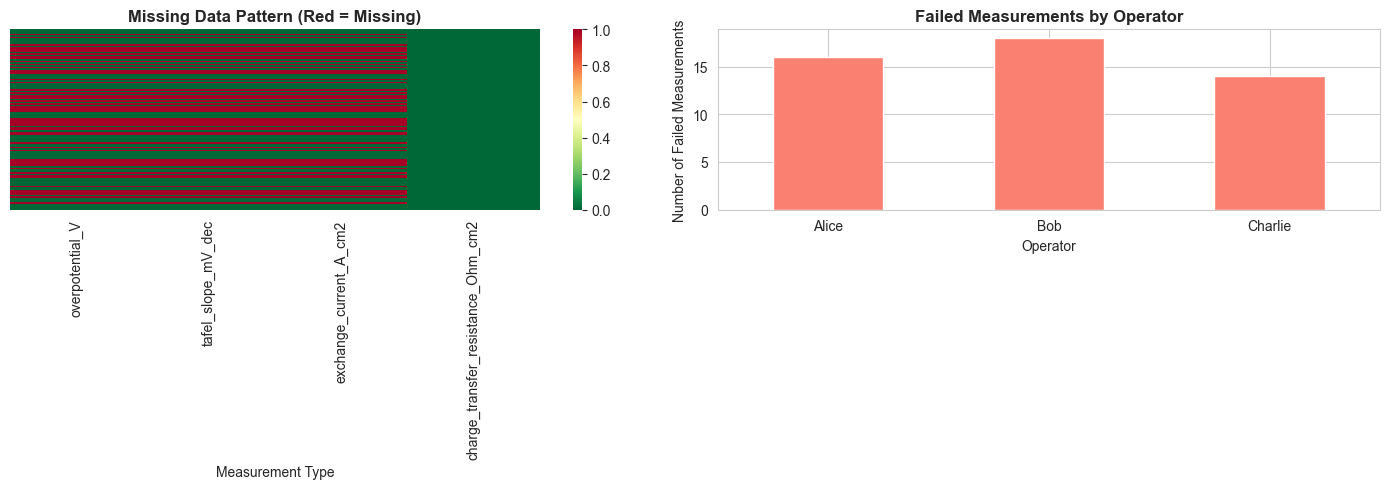


🔍 Key Finding: 162 total missing values across electrochemical metrics


In [4]:
# Calculate missing data statistics
missing_stats = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("Missing Data Summary:")
print(missing_stats)

# Visualize missing data patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Missing data heatmap
ax1 = axes[0]
sns.heatmap(df[['overpotential_V', 'tafel_slope_mV_dec', 'exchange_current_A_cm2', 
                'charge_transfer_resistance_Ohm_cm2']].isnull(), 
            cbar=True, yticklabels=False, cmap='RdYlGn_r', ax=ax1)
ax1.set_title('Missing Data Pattern (Red = Missing)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Measurement Type')

# Missing data by operator
ax2 = axes[1]
operator_missing = df.groupby('operator')['measurement_quality'].apply(lambda x: (x == 0).sum())
operator_missing.plot(kind='bar', color='salmon', ax=ax2)
ax2.set_title('Failed Measurements by Operator', fontsize=12, fontweight='bold')
ax2.set_xlabel('Operator')
ax2.set_ylabel('Number of Failed Measurements')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print(f"\n🔍 Key Finding: {missing_stats['Missing_Count'].sum()} total missing values across electrochemical metrics")

## 4. Temperature Drift Analysis

**Electrochemical context:** Temperature significantly affects:
- **Reaction kinetics** (Arrhenius relationship)
- **Mass transport** (diffusion coefficients)
- **Thermodynamic potentials** (Nernst equation: ~0.8 mV/°C for OER)

A 1°C drift can introduce ~2-3 mV error in overpotential measurements. For high-throughput screening, we need to check if temperature was controlled properly throughout the campaign.

Temperature Statistics:
  Mean: 25.09°C
  Std Dev: 0.47°C
  Range: 2.36°C (23.90 - 26.26°C)
  Expected overpotential error: ±1.9 mV


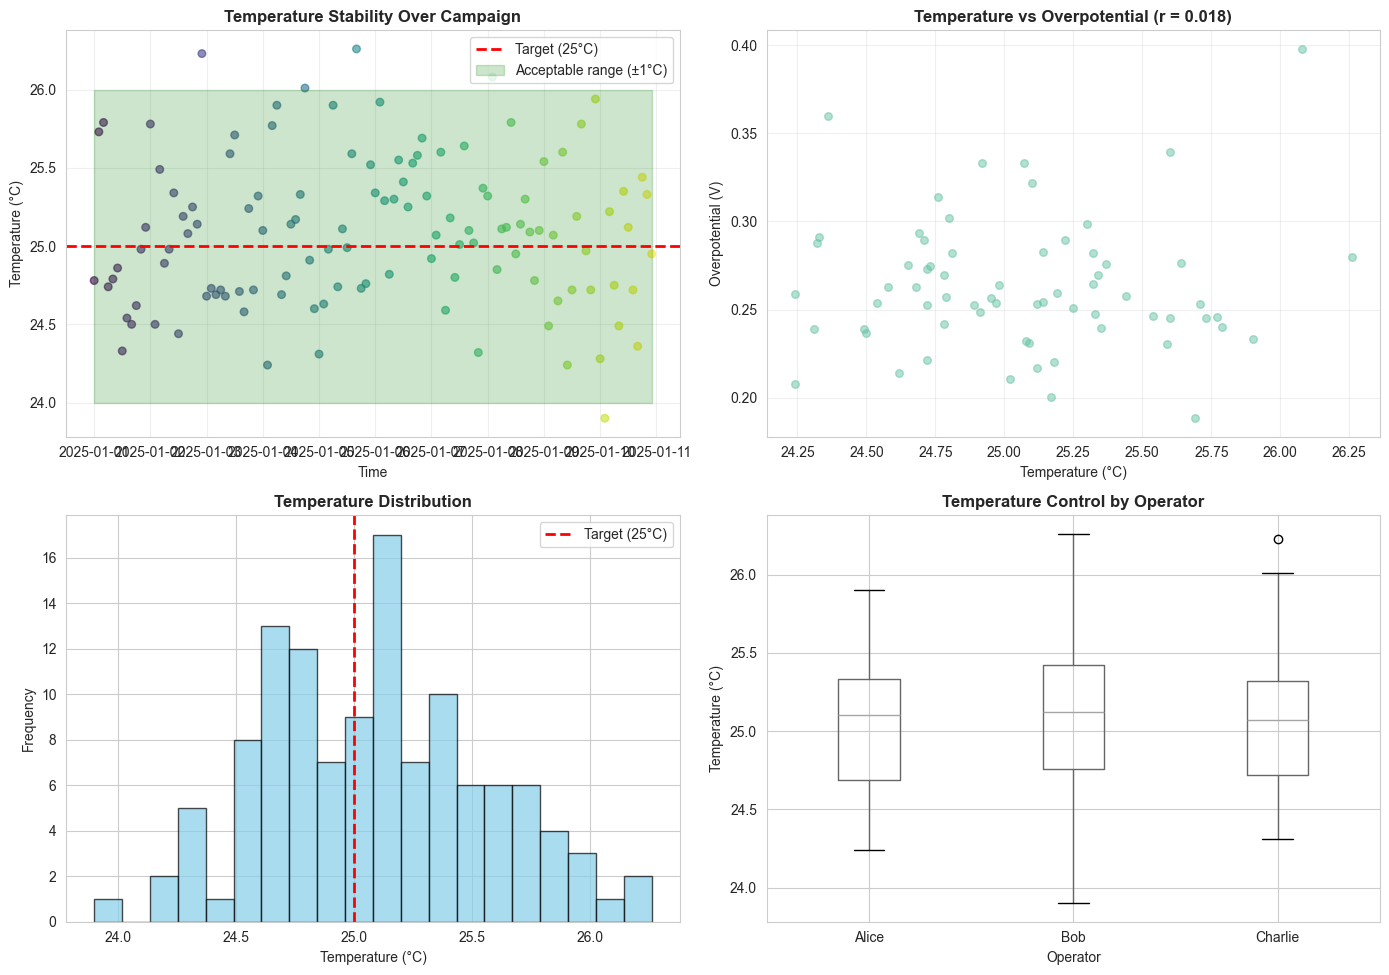


⚠️ WARNING: Temperature range exceeds 2°C - may introduce systematic errors


In [5]:
# Analyze temperature control
temp_stats = df['temperature_C'].describe()
temp_range = temp_stats['max'] - temp_stats['min']

print(f"Temperature Statistics:")
print(f"  Mean: {temp_stats['mean']:.2f}°C")
print(f"  Std Dev: {temp_stats['std']:.2f}°C")
print(f"  Range: {temp_range:.2f}°C ({temp_stats['min']:.2f} - {temp_stats['max']:.2f}°C)")
print(f"  Expected overpotential error: ±{temp_range * 0.8:.1f} mV")

# Visualize temperature drift over time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Temperature vs time
ax1 = axes[0, 0]
ax1.scatter(df['timestamp'], df['temperature_C'], alpha=0.6, s=30, c=df.index, cmap='viridis')
ax1.axhline(y=25, color='red', linestyle='--', label='Target (25°C)', linewidth=2)
ax1.fill_between(df['timestamp'], 24, 26, alpha=0.2, color='green', label='Acceptable range (±1°C)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Temperature Stability Over Campaign', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Temperature vs overpotential (should be no correlation if controlled)
ax2 = axes[0, 1]
df_valid = df.dropna(subset=['overpotential_V', 'temperature_C'])
ax2.scatter(df_valid['temperature_C'], df_valid['overpotential_V'], alpha=0.5, s=30)
correlation = df_valid[['temperature_C', 'overpotential_V']].corr().iloc[0, 1]
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Overpotential (V)')
ax2.set_title(f'Temperature vs Overpotential (r = {correlation:.3f})', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Temperature distribution
ax3 = axes[1, 0]
ax3.hist(df['temperature_C'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
ax3.axvline(x=25, color='red', linestyle='--', label='Target (25°C)', linewidth=2)
ax3.set_xlabel('Temperature (°C)')
ax3.set_ylabel('Frequency')
ax3.set_title('Temperature Distribution', fontweight='bold')
ax3.legend()

# Temperature by operator
ax4 = axes[1, 1]
df.boxplot(column='temperature_C', by='operator', ax=ax4)
ax4.set_xlabel('Operator')
ax4.set_ylabel('Temperature (°C)')
ax4.set_title('Temperature Control by Operator', fontweight='bold')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

# Statistical assessment
if temp_range > 2:
    print(f"\n⚠️ WARNING: Temperature range exceeds 2°C - may introduce systematic errors")
else:
    print(f"\n✓ Temperature control acceptable (range < 2°C)")

## 5. Replicate Consistency Analysis

**Why replicates matter:** In electrochemistry, measurement reproducibility is challenging due to:
- Surface preparation variability (electrode polishing, catalyst loading)
- Electrolyte aging
- Reference electrode drift
- Instrument noise

The `replicate_std` column contains the standard deviation across triplicate measurements. High std values indicate unreliable data.

Replicate Consistency Statistics:
  Mean std: 0.0171
  Median std: 0.0180
  Max std: 0.0299

⚠️ 20 samples (16.7%) have poor replicate consistency (std > 0.025)


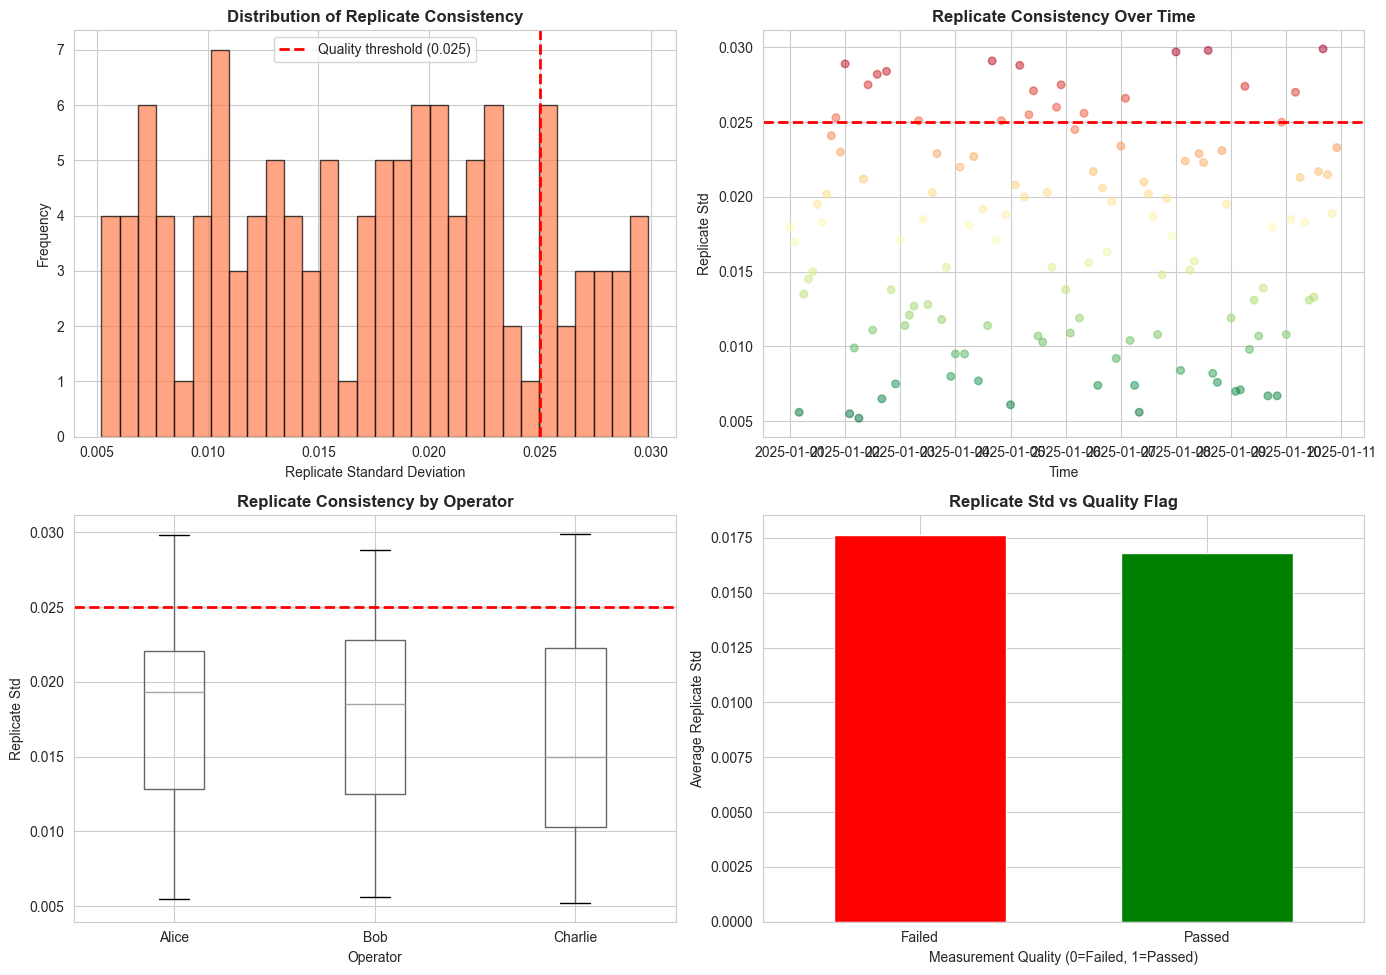


📋 Samples requiring re-measurement (poor replicates):
     sample_id  replicate_std operator    instrument_id
10  CAT-01-011         0.0253      Bob  POTENTIOSTAT-01
12  CAT-01-013         0.0289    Alice  POTENTIOSTAT-01
17  CAT-01-018         0.0275  Charlie  POTENTIOSTAT-01
19  CAT-01-020         0.0282  Charlie  POTENTIOSTAT-01
21  CAT-01-022         0.0284    Alice  POTENTIOSTAT-01
28  CAT-01-029         0.0251  Charlie  POTENTIOSTAT-01
44  CAT-01-045         0.0291    Alice  POTENTIOSTAT-01
46  CAT-01-047         0.0251      Bob  POTENTIOSTAT-01
50  CAT-01-051         0.0288      Bob  POTENTIOSTAT-01
52  CAT-01-053         0.0255      Bob  POTENTIOSTAT-01


In [6]:
# Analyze replicate consistency
rep_stats = df['replicate_std'].describe()

print(f"Replicate Consistency Statistics:")
print(f"  Mean std: {rep_stats['mean']:.4f}")
print(f"  Median std: {rep_stats['50%']:.4f}")
print(f"  Max std: {rep_stats['max']:.4f}")

# Define quality threshold (std > 0.025 is concerning for electrochemical measurements)
threshold = 0.025
poor_replicates = df[df['replicate_std'] > threshold]
print(f"\n⚠️ {len(poor_replicates)} samples ({len(poor_replicates)/len(df)*100:.1f}%) have poor replicate consistency (std > {threshold})")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Replicate std distribution
ax1 = axes[0, 0]
ax1.hist(df['replicate_std'], bins=30, edgecolor='black', alpha=0.7, color='coral')
ax1.axvline(x=threshold, color='red', linestyle='--', label=f'Quality threshold ({threshold})', linewidth=2)
ax1.set_xlabel('Replicate Standard Deviation')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Replicate Consistency', fontweight='bold')
ax1.legend()

# Replicate std over time (degradation of equipment?)
ax2 = axes[0, 1]
ax2.scatter(df['timestamp'], df['replicate_std'], alpha=0.5, s=30, c=df['replicate_std'], cmap='RdYlGn_r')
ax2.axhline(y=threshold, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Time')
ax2.set_ylabel('Replicate Std')
ax2.set_title('Replicate Consistency Over Time', fontweight='bold')

# Replicate std by operator
ax3 = axes[1, 0]
df.boxplot(column='replicate_std', by='operator', ax=ax3)
ax3.axhline(y=threshold, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Operator')
ax3.set_ylabel('Replicate Std')
ax3.set_title('Replicate Consistency by Operator', fontweight='bold')
plt.suptitle('')

# Relationship between replicate std and measurement quality flag
ax4 = axes[1, 1]
quality_groups = df.groupby('measurement_quality')['replicate_std'].mean()
colors = ['red', 'green']
quality_groups.plot(kind='bar', color=colors, ax=ax4, width=0.6)
ax4.set_xlabel('Measurement Quality (0=Failed, 1=Passed)')
ax4.set_ylabel('Average Replicate Std')
ax4.set_title('Replicate Std vs Quality Flag', fontweight='bold')
ax4.set_xticklabels(['Failed', 'Passed'], rotation=0)

plt.tight_layout()
plt.show()

# Identify samples that need to be repeated
print(f"\n📋 Samples requiring re-measurement (poor replicates):")
print(poor_replicates[['sample_id', 'replicate_std', 'operator', 'instrument_id']].head(10))

## 6. Statistical Outlier Detection

We'll use **z-score analysis** to identify statistical outliers in key electrochemical metrics. However, we need electrochemical context - some "outliers" might be:
- **Real discoveries** (unexpectedly high activity)
- **Artifacts** (electrode fouling, measurement errors)

The data scientist's job is to flag outliers and determine which warrant investigation vs. exclusion.

Statistical Outlier Summary (|z-score| > 3):
overpotential_V: 1 outliers (1.4%)
tafel_slope_mV_dec: 0 outliers (0.0%)
exchange_current_A_cm2: 2 outliers (2.8%)
charge_transfer_resistance_Ohm_cm2: 1 outliers (1.4%)


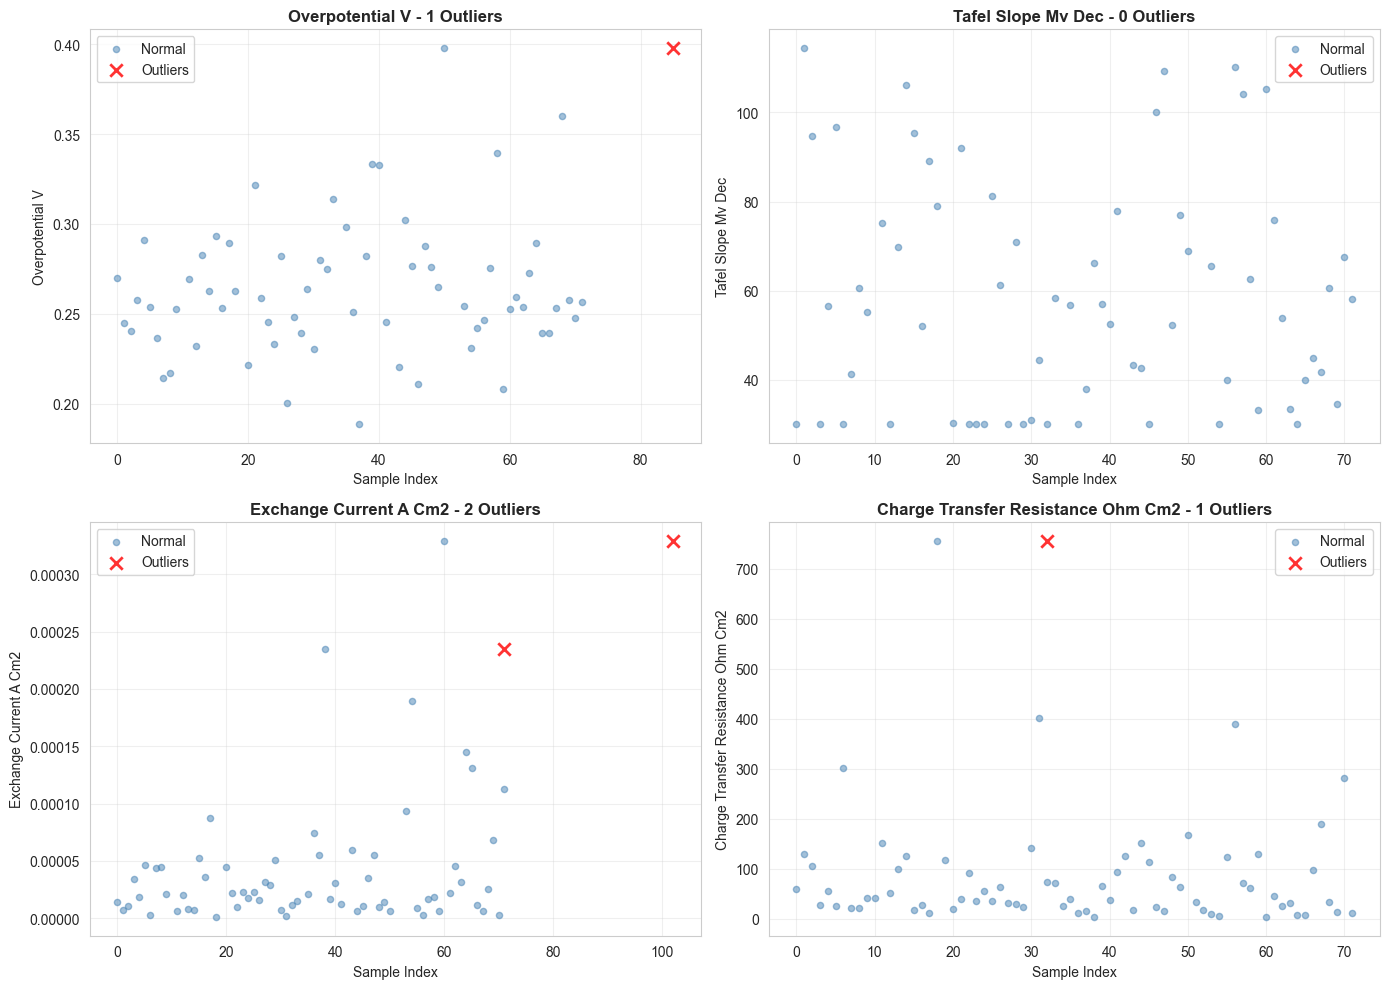


🔍 Extreme Outliers Requiring Investigation:

overpotential_V:
     sample_id  overpotential_V  overpotential_V_zscore operator  \
85  CAT-01-086           0.3978                3.613757      Bob   

    replicate_std  Pt_percent  Ru_percent  Ir_percent  
85         0.0084        53.0        10.3        36.7  

exchange_current_A_cm2:
      sample_id  exchange_current_A_cm2  exchange_current_A_cm2_zscore  \
71   CAT-01-072                0.000235                       3.456376   
102  CAT-01-103                0.000329                       5.132262   

    operator  replicate_std  Pt_percent  Ru_percent  Ir_percent  
71     Alice         0.0092        47.9        36.9        15.1  
102  Charlie         0.0107        52.6        12.8        34.6  

charge_transfer_resistance_Ohm_cm2:
     sample_id  charge_transfer_resistance_Ohm_cm2  \
32  CAT-01-033                              755.81   

    charge_transfer_resistance_Ohm_cm2_zscore operator  replicate_std  \
32                     

In [8]:
# Calculate z-scores for key metrics
metrics = ['overpotential_V', 'tafel_slope_mV_dec', 'exchange_current_A_cm2', 
           'charge_transfer_resistance_Ohm_cm2']

# Create a copy with only valid measurements
df_valid = df[df['measurement_quality'] == 1].copy()

# Calculate z-scores (zscore handles NaN values automatically)
for metric in metrics:
    df_valid[f'{metric}_zscore'] = zscore(df_valid[metric], nan_policy='omit')

# Define outlier threshold (|z| > 3)
z_threshold = 3
outliers = {}

for metric in metrics:
    outliers[metric] = df_valid[abs(df_valid[f'{metric}_zscore']) > z_threshold]

# Summary
print("Statistical Outlier Summary (|z-score| > 3):")
print("=" * 60)
for metric, outlier_df in outliers.items():
    print(f"{metric}: {len(outlier_df)} outliers ({len(outlier_df)/len(df_valid)*100:.1f}%)")

# Visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    # Plot all points
    ax.scatter(range(len(df_valid)), df_valid[metric], alpha=0.5, s=20, label='Normal', color='steelblue')
    
    # Highlight outliers
    outlier_indices = outliers[metric].index
    ax.scatter(outlier_indices, df_valid.loc[outlier_indices, metric], 
               color='red', s=80, alpha=0.8, label='Outliers', marker='x', linewidths=2)
    
    ax.set_xlabel('Sample Index')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} - {len(outliers[metric])} Outliers', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Investigate extreme outliers
print(f"\n🔍 Extreme Outliers Requiring Investigation:")
print("=" * 60)
for metric in metrics:
    if len(outliers[metric]) > 0:
        print(f"\n{metric}:")
        print(outliers[metric][['sample_id', metric, f'{metric}_zscore', 'operator', 
                                 'replicate_std', 'Pt_percent', 'Ru_percent', 'Ir_percent']].head(3))

## 7. Measurement Quality Assessment

Let's analyze the overall success rate and identify patterns in measurement failures.

Overall Measurement Success Rate: 60.0% (72/120)

Success Rate by Operator:
          Successful  Total  Success_Rate_%
operator                                   
Charlie           27     41       65.853659
Bob               25     43       58.139535
Alice             20     36       55.555556


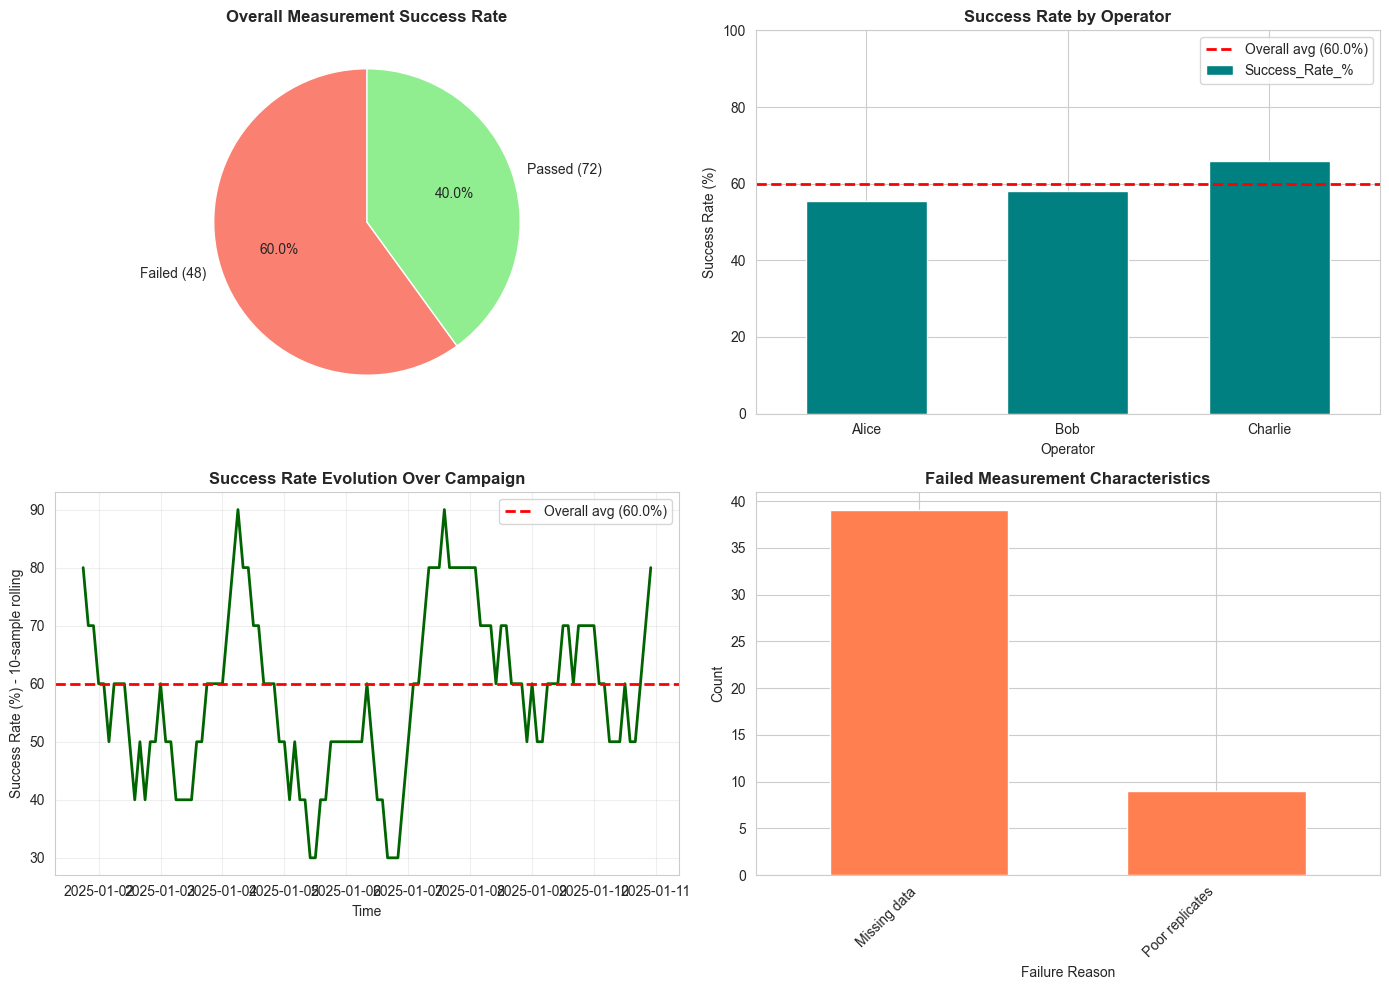


📊 Key Quality Insights:
  • Overall success rate: 60.0%
  • Best operator: Charlie (65.9%)
  • Worst operator: Alice (55.6%)
  • Failed measurements: 48 samples


In [9]:
# Calculate success rates
total_samples = len(df)
successful_measurements = (df['measurement_quality'] == 1).sum()
success_rate = successful_measurements / total_samples * 100

print(f"Overall Measurement Success Rate: {success_rate:.1f}% ({successful_measurements}/{total_samples})")

# Success rate by operator
operator_success = df.groupby('operator').agg({
    'measurement_quality': ['sum', 'count', lambda x: (x.sum() / x.count() * 100)]
})
operator_success.columns = ['Successful', 'Total', 'Success_Rate_%']
print(f"\nSuccess Rate by Operator:")
print(operator_success.sort_values('Success_Rate_%', ascending=False))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall success pie chart
ax1 = axes[0, 0]
success_counts = df['measurement_quality'].value_counts()
colors = ['salmon', 'lightgreen']
labels = [f'Failed ({success_counts[0]})', f'Passed ({success_counts[1]})']
ax1.pie(success_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title(f'Overall Measurement Success Rate', fontweight='bold')

# Success rate by operator
ax2 = axes[0, 1]
operator_success['Success_Rate_%'].plot(kind='bar', color='teal', ax=ax2, width=0.6)
ax2.axhline(y=success_rate, color='red', linestyle='--', label=f'Overall avg ({success_rate:.1f}%)', linewidth=2)
ax2.set_xlabel('Operator')
ax2.set_ylabel('Success Rate (%)')
ax2.set_title('Success Rate by Operator', fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.legend()
ax2.set_ylim([0, 100])

# Success rate over time
ax3 = axes[1, 0]
df_time = df.set_index('timestamp')
df_time['success_rate_rolling'] = df_time['measurement_quality'].rolling(window=10).mean() * 100
ax3.plot(df_time.index, df_time['success_rate_rolling'], linewidth=2, color='darkgreen')
ax3.axhline(y=success_rate, color='red', linestyle='--', label=f'Overall avg ({success_rate:.1f}%)', linewidth=2)
ax3.set_xlabel('Time')
ax3.set_ylabel('Success Rate (%) - 10-sample rolling')
ax3.set_title('Success Rate Evolution Over Campaign', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Failed measurements characteristics
ax4 = axes[1, 1]
failed_samples = df[df['measurement_quality'] == 0]
failure_reasons = []
for idx, row in failed_samples.iterrows():
    if row['replicate_std'] > 0.025:
        failure_reasons.append('Poor replicates')
    elif pd.isna(row['overpotential_V']):
        failure_reasons.append('Missing data')
    else:
        failure_reasons.append('Other')

failure_counts = pd.Series(failure_reasons).value_counts()
failure_counts.plot(kind='bar', color='coral', ax=ax4, width=0.6)
ax4.set_xlabel('Failure Reason')
ax4.set_ylabel('Count')
ax4.set_title('Failed Measurement Characteristics', fontweight='bold')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Key insights
print(f"\n📊 Key Quality Insights:")
print(f"  • Overall success rate: {success_rate:.1f}%")
print(f"  • Best operator: {operator_success['Success_Rate_%'].idxmax()} ({operator_success['Success_Rate_%'].max():.1f}%)")
print(f"  • Worst operator: {operator_success['Success_Rate_%'].idxmin()} ({operator_success['Success_Rate_%'].min():.1f}%)")
print(f"  • Failed measurements: {len(failed_samples)} samples")

## 8. Summary & Recommendations

### Data Quality Report Card for Campaign 1

**What we found:**

In [10]:
# Generate comprehensive summary
print("="*70)
print("CAMPAIGN 1: DATA QUALITY ASSESSMENT SUMMARY")
print("="*70)

# Missing data
missing_rate = (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100
print(f"\n1. MISSING DATA")
print(f"   Overall missing rate: {missing_rate:.2f}%")
print(f"   Critical metrics with missing data:")
for col in ['overpotential_V', 'tafel_slope_mV_dec', 'exchange_current_A_cm2']:
    missing_pct = (df[col].isnull().sum() / len(df)) * 100
    print(f"     • {col}: {missing_pct:.1f}%")

# Temperature control
print(f"\n2. TEMPERATURE CONTROL")
print(f"   Range: {temp_range:.2f}°C")
print(f"   Estimated error: ±{temp_range * 0.8:.1f} mV")
if temp_range > 2:
    print(f"   Status: ⚠️ NEEDS IMPROVEMENT")
else:
    print(f"   Status: ✓ ACCEPTABLE")

# Replicate consistency
poor_rep_pct = (len(poor_replicates) / len(df)) * 100
print(f"\n3. REPLICATE CONSISTENCY")
print(f"   Samples with poor replicates: {len(poor_replicates)} ({poor_rep_pct:.1f}%)")
print(f"   Mean std: {rep_stats['mean']:.4f}")
if poor_rep_pct > 20:
    print(f"   Status: ⚠️ NEEDS IMPROVEMENT")
else:
    print(f"   Status: ✓ ACCEPTABLE")

# Outliers
total_outliers = sum([len(outliers[m]) for m in metrics])
outlier_pct = (total_outliers / (len(df_valid) * len(metrics))) * 100
print(f"\n4. STATISTICAL OUTLIERS")
print(f"   Total outliers (|z| > 3): {total_outliers} ({outlier_pct:.1f}%)")
print(f"   Breakdown:")
for metric in metrics:
    print(f"     • {metric}: {len(outliers[metric])}")

# Overall quality
print(f"\n5. MEASUREMENT SUCCESS RATE")
print(f"   Overall: {success_rate:.1f}%")
print(f"   By operator:")
for op in operator_success.index:
    rate = operator_success.loc[op, 'Success_Rate_%']
    print(f"     • {op}: {rate:.1f}%")

# Final grade
if success_rate >= 75 and temp_range < 2 and poor_rep_pct < 15:
    grade = "A - Excellent"
elif success_rate >= 60 and temp_range < 3:
    grade = "B - Good"
elif success_rate >= 50:
    grade = "C - Acceptable"
else:
    grade = "D - Needs Improvement"

print(f"\n{'='*70}")
print(f"OVERALL GRADE: {grade}")
print(f"{'='*70}")

# Actionable recommendations
print(f"\n📋 RECOMMENDATIONS FOR CAMPAIGN 2:")
print(f"   1. Operator training: Focus on {operator_success['Success_Rate_%'].idxmin()}")
print(f"   2. Temperature control: Improve bath stability (target ±0.5°C)")
print(f"   3. Re-measure: {len(poor_replicates)} samples with poor replicates")
print(f"   4. Investigate outliers: {total_outliers} measurements need validation")
print(f"   5. Protocol review: Standardize measurement procedures across operators")
print(f"\n✓ Analysis complete!")

CAMPAIGN 1: DATA QUALITY ASSESSMENT SUMMARY

1. MISSING DATA
   Overall missing rate: 7.94%
   Critical metrics with missing data:
     • overpotential_V: 45.0%
     • tafel_slope_mV_dec: 45.0%
     • exchange_current_A_cm2: 45.0%

2. TEMPERATURE CONTROL
   Range: 2.36°C
   Estimated error: ±1.9 mV
   Status: ⚠️ NEEDS IMPROVEMENT

3. REPLICATE CONSISTENCY
   Samples with poor replicates: 20 (16.7%)
   Mean std: 0.0171
   Status: ✓ ACCEPTABLE

4. STATISTICAL OUTLIERS
   Total outliers (|z| > 3): 4 (1.4%)
   Breakdown:
     • overpotential_V: 1
     • tafel_slope_mV_dec: 0
     • exchange_current_A_cm2: 2
     • charge_transfer_resistance_Ohm_cm2: 1

5. MEASUREMENT SUCCESS RATE
   Overall: 60.0%
   By operator:
     • Alice: 55.6%
     • Bob: 58.1%
     • Charlie: 65.9%

OVERALL GRADE: B - Good

📋 RECOMMENDATIONS FOR CAMPAIGN 2:
   1. Operator training: Focus on Alice
   2. Temperature control: Improve bath stability (target ±0.5°C)
   3. Re-measure: 20 samples with poor replicates
   4.